In [18]:
import tensorflow
import pandas as pd
import time
import numpy as np

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
import matplotlib.pyplot as plt

# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import sys
from datetime import datetime
np.set_printoptions(threshold=sys.maxsize)

# Read Data

In [19]:
df = pd.read_csv('./features_30_sec.csv')
df1 = df.sample(frac = 1)
df.head()
print(df.shape)

(1000, 60)


In [20]:
df['label'].value_counts()

disco        100
metal        100
jazz         100
reggae       100
classical    100
rock         100
hiphop       100
pop          100
country      100
blues        100
Name: label, dtype: int64

Split and scale dataset

In [21]:
columns_to_drop = ['label','filename', 'length']

def prepare_dataset(df, columns_to_drop, test_size, random_state,Kfold = False,start_train = None, start_test = None):

    # Encode the labels from 0 to n_classes-1  
    label_encoder = preprocessing.LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
  
    # devide data to train and test
    if Kfold:
        # print("startTrain",start_train)
        # print("endTrain",end_train)
        # print("startTest",start_test)
        # print("endTest",type(start_test))
        
        df_train = df.iloc[start_train,:]
        df_test = df.iloc[start_test,:]
    else:
        df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
        
    
    # print(df_test.index)
    # print(df_train.index)
    
    # scale the training inputs
    x_train = df_train.drop(columns_to_drop,axis=1)
    y_train = df_train['label'].to_numpy()
    
    standard_scaler = preprocessing.StandardScaler()
    x_train_scaled = standard_scaler.fit_transform(x_train)

    #scale and prepare testing data
    x_test = df_test.drop(columns_to_drop,axis=1)
    x_test_scaled = standard_scaler.transform(x_test)
    y_test = df_test['label'].to_numpy() 
  
    return x_train_scaled, y_train, x_test_scaled, y_test


In [22]:
X_train, y_train, X_test, y_test = prepare_dataset(df, columns_to_drop, test_size=0.3, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Converting Lables to one-hot encoding
def toOneHot(y_):
    y = np.zeros((y_.shape[0],10))
    for x in range(len(y)):
        y[x,y_[x]] = 1
    return y
y_train_hot = toOneHot(y_train)
y_test_hot = toOneHot(y_test)

(700, 57) (700,)
(300, 57) (300,)


##Designing Model Question1

In [23]:
kf = KFold(n_splits=3)
kf.get_n_splits(df)
EPOCHS = []
class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        self.epochs = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = tf.timestamp()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append((tf.timestamp() - self.timetaken).numpy() )
        self.epochs.append(epoch)
    def on_epoch_begin(self,epoch,logs = {}):
        self.timetaken = tf.timestamp()
    def on_train_end(self,logs = {}):
        global EPOCHS
        EPOCHS.append(sum(self.times)/len(self.times))

timecallbackobject = timecallback()

In [24]:
def createModel(neurons, layers, dropout = True):
    model = Sequential()

    model.add(Input(shape = (57,)))

    for x in range(layers):
        model.add(Dense(neurons,activation = "ReLU"))
        if dropout:
            model.add(Dropout(0.3))

    model.add(Dense(10,activation = "softmax"))
    model.compile(optimizer='adam',loss= tf.keras.losses.MeanSquaredError(),metrics =["accuracy"] )
    return model
model = createModel(16,1)


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                928       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                170       
Total params: 1,098
Trainable params: 1,098
Non-trainable params: 0
_________________________________________________________________


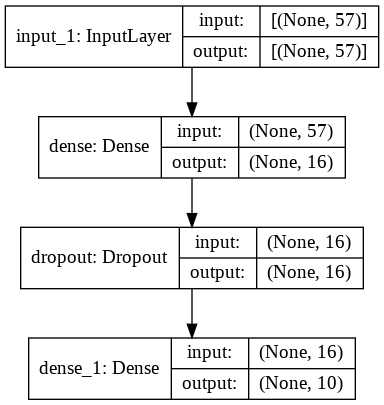

In [11]:
keras.utils.plot_model(model, show_shapes=True)

In [10]:
def trainModel(model,X_train,y_train_hot,X_test,y_test_hot,batch_size,customCallBack):
    history = model.fit(
        X_train,
        y_train_hot,
        batch_size=batch_size,
        epochs=50,
        verbose = 1,
        validation_data=(X_test, y_test_hot),
        callbacks=[customCallBack]
    )
    return history
history = trainModel(model,X_train,y_train_hot,X_test,y_test_hot,1,timecallbackobject)

Epoch 1/50
700/700 [==============================] - 1s 741us/step - loss: 0.0877 - accuracy: 0.2071 - val_loss: 0.0799 - val_accuracy: 0.3267
Epoch 2/50
700/700 [==============================] - 0s 601us/step - loss: 0.0739 - accuracy: 0.3886 - val_loss: 0.0720 - val_accuracy: 0.4200
Epoch 3/50
700/700 [==============================] - 0s 602us/step - loss: 0.0685 - accuracy: 0.4343 - val_loss: 0.0654 - val_accuracy: 0.4967
Epoch 4/50
700/700 [==============================] - 0s 568us/step - loss: 0.0629 - accuracy: 0.4914 - val_loss: 0.0631 - val_accuracy: 0.5200
Epoch 5/50
700/700 [==============================] - 0s 582us/step - loss: 0.0593 - accuracy: 0.5386 - val_loss: 0.0590 - val_accuracy: 0.5533
Epoch 6/50
700/700 [==============================] - 0s 599us/step - loss: 0.0574 - accuracy: 0.5586 - val_loss: 0.0570 - val_accuracy: 0.5733
Epoch 7/50
700/700 [==============================] - 0s 588us/step - loss: 0.0545 - accuracy: 0.5800 - val_loss: 0.0560 - val_accuracy:

In [11]:
preds_hot = model.predict(X_train)
preds = preds_hot.argmax(axis = 1)
print("accuracy", ( ( preds.shape[0] - np.count_nonzero( preds-y_train )  ) / preds.shape[0] )* 100, "%")

accuracy 89.14285714285714 %


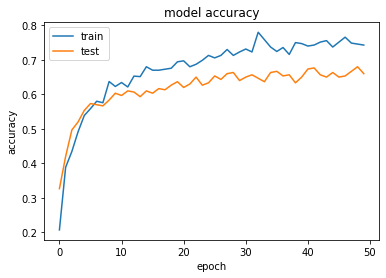

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

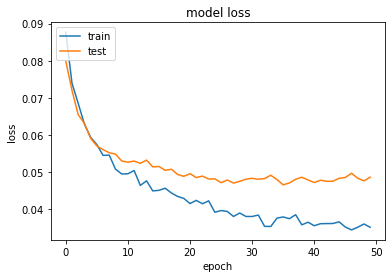

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Question 2

In [25]:
train_ = []
test_ = []
for train_indices, test_indices in kf.split(df.index):
    train_.append(train_indices)
    test_.append(test_indices)

In [26]:
hists = []
batch_sizes = [64,32,16,8,4,1]
for BATCH in batch_sizes:
    hist_list = []
    for _ind in range(3):
        print("Training For Batch Size",BATCH,"Cross Val",_ind)
        X_train, y_train, X_test, y_test = prepare_dataset(df1, columns_to_drop, test_size=0.3, random_state=0,Kfold = True, start_train= train_[_ind], start_test= test_[_ind])

        y_train_hot = toOneHot(y_train)
        y_test_hot = toOneHot(y_test)

        model = createModel(16,1)
        history = trainModel(model,X_train,y_train_hot,X_test,y_test_hot,BATCH,timecallbackobject)
        hist_list.append(history)
        
    aveacc = ( ( np.array(hist_list[0].history["accuracy"]) + np.array(hist_list[1].history["accuracy"]) + np.array(hist_list[2].history["accuracy"]) )/3 )
    batchDict = {str(BATCH):{"0":hist_list[0],"1":hist_list[1],"2":hist_list[2],"ave_accuracy":aveacc,"ave_time":( sum(EPOCHS)/len(EPOCHS) ) }}    
    hists.append(batchDict)
    EPOCHS.clear()

Training For Batch Size 64 Cross Val 0
Epoch 1/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0999 - accuracy: 0.0721 - val_loss: 0.0971 - val_accuracy: 0.0868
Epoch 2/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0967 - accuracy: 0.1231 - val_loss: 0.0947 - val_accuracy: 0.1048
Epoch 3/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0941 - accuracy: 0.1306 - val_loss: 0.0923 - val_accuracy: 0.1527
Epoch 4/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0918 - accuracy: 0.1607 - val_loss: 0.0900 - val_accuracy: 0.2066
Epoch 5/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0911 - accuracy: 0.1847 - val_loss: 0.0880 - val_accuracy: 0.2335
Epoch 6/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0870 - accuracy: 0.2568 - val_loss: 0.0861 - val_accuracy: 0.2515
Epoch 7/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0859 - accuracy: 0.2703 - val_loss: 0.0841 - va

11/11 [==============================] - 0s 2ms/step - loss: 0.0835 - accuracy: 0.2804 - val_loss: 0.0824 - val_accuracy: 0.2793
Epoch 9/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0813 - accuracy: 0.3028 - val_loss: 0.0814 - val_accuracy: 0.2853
Epoch 10/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0812 - accuracy: 0.2954 - val_loss: 0.0805 - val_accuracy: 0.3033
Epoch 11/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0802 - accuracy: 0.2954 - val_loss: 0.0796 - val_accuracy: 0.3183
Epoch 12/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0785 - accuracy: 0.3133 - val_loss: 0.0786 - val_accuracy: 0.3333
Epoch 13/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0775 - accuracy: 0.3553 - val_loss: 0.0775 - val_accuracy: 0.3544
Epoch 14/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0760 - accuracy: 0.3658 - val_loss: 0.0765 - val_accuracy: 0.3724
Epoch 15/50
11/11 [=======

Epoch 16/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0730 - accuracy: 0.4048 - val_loss: 0.0689 - val_accuracy: 0.4565
Epoch 17/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0729 - accuracy: 0.3838 - val_loss: 0.0682 - val_accuracy: 0.4565
Epoch 18/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0716 - accuracy: 0.4123 - val_loss: 0.0674 - val_accuracy: 0.4595
Epoch 19/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0710 - accuracy: 0.4198 - val_loss: 0.0667 - val_accuracy: 0.4745
Epoch 20/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0694 - accuracy: 0.4393 - val_loss: 0.0659 - val_accuracy: 0.4835
Epoch 21/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0702 - accuracy: 0.4438 - val_loss: 0.0651 - val_accuracy: 0.4895
Epoch 22/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0690 - accuracy: 0.4558 - val_loss: 0.0644 - val_accuracy: 0.4895
Epoch 23/50
1

Epoch 22/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0650 - accuracy: 0.4610 - val_loss: 0.0605 - val_accuracy: 0.5419
Epoch 23/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0632 - accuracy: 0.4850 - val_loss: 0.0597 - val_accuracy: 0.5449
Epoch 24/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0642 - accuracy: 0.4805 - val_loss: 0.0591 - val_accuracy: 0.5509
Epoch 25/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0630 - accuracy: 0.5075 - val_loss: 0.0589 - val_accuracy: 0.5299
Epoch 26/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0617 - accuracy: 0.5255 - val_loss: 0.0582 - val_accuracy: 0.5359
Epoch 27/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0614 - accuracy: 0.5165 - val_loss: 0.0577 - val_accuracy: 0.5449
Epoch 28/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0609 - accuracy: 0.5045 - val_loss: 0.0572 - val_accuracy: 0.5659
Epoch 29/50
2

Epoch 30/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0547 - accuracy: 0.5727 - val_loss: 0.0602 - val_accuracy: 0.5225
Epoch 31/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0558 - accuracy: 0.5667 - val_loss: 0.0599 - val_accuracy: 0.5255
Epoch 32/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0556 - accuracy: 0.5592 - val_loss: 0.0595 - val_accuracy: 0.5375
Epoch 33/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0527 - accuracy: 0.5907 - val_loss: 0.0594 - val_accuracy: 0.5495
Epoch 34/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0538 - accuracy: 0.5682 - val_loss: 0.0592 - val_accuracy: 0.5405
Epoch 35/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0527 - accuracy: 0.6042 - val_loss: 0.0588 - val_accuracy: 0.5405
Epoch 36/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0526 - accuracy: 0.5877 - val_loss: 0.0582 - val_accuracy: 0.5616
Epoch 37/50
2

Epoch 38/50
21/21 [==============================] - 0s 2ms/step - loss: 0.0544 - accuracy: 0.5592 - val_loss: 0.0542 - val_accuracy: 0.6096
Epoch 39/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0548 - accuracy: 0.5562 - val_loss: 0.0539 - val_accuracy: 0.6156
Epoch 40/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0518 - accuracy: 0.6072 - val_loss: 0.0535 - val_accuracy: 0.6186
Epoch 41/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0519 - accuracy: 0.5997 - val_loss: 0.0530 - val_accuracy: 0.6336
Epoch 42/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0525 - accuracy: 0.5982 - val_loss: 0.0527 - val_accuracy: 0.6276
Epoch 43/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0534 - accuracy: 0.5787 - val_loss: 0.0523 - val_accuracy: 0.6336
Epoch 44/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0526 - accuracy: 0.6102 - val_loss: 0.0520 - val_accuracy: 0.6306
Epoch 45/50
2

42/42 [==============================] - 0s 949us/step - loss: 0.0471 - accuracy: 0.6426 - val_loss: 0.0481 - val_accuracy: 0.6287
Epoch 46/50
42/42 [==============================] - 0s 973us/step - loss: 0.0479 - accuracy: 0.6456 - val_loss: 0.0478 - val_accuracy: 0.6437
Epoch 47/50
42/42 [==============================] - 0s 973us/step - loss: 0.0480 - accuracy: 0.6441 - val_loss: 0.0470 - val_accuracy: 0.6347
Epoch 48/50
42/42 [==============================] - 0s 924us/step - loss: 0.0479 - accuracy: 0.6411 - val_loss: 0.0473 - val_accuracy: 0.6377
Epoch 49/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0463 - accuracy: 0.6712 - val_loss: 0.0477 - val_accuracy: 0.6198
Epoch 50/50
42/42 [==============================] - 0s 949us/step - loss: 0.0463 - accuracy: 0.6622 - val_loss: 0.0471 - val_accuracy: 0.6377
Training For Batch Size 16 Cross Val 1
Epoch 1/50
42/42 [==============================] - 0s 3ms/step - loss: 0.0935 - accuracy: 0.1349 - val_loss: 0.0863 

42/42 [==============================] - 0s 997us/step - loss: 0.0945 - accuracy: 0.1349 - val_loss: 0.0897 - val_accuracy: 0.1682
Epoch 3/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0900 - accuracy: 0.1829 - val_loss: 0.0860 - val_accuracy: 0.2312
Epoch 4/50
42/42 [==============================] - 0s 997us/step - loss: 0.0857 - accuracy: 0.2369 - val_loss: 0.0826 - val_accuracy: 0.2793
Epoch 5/50
42/42 [==============================] - 0s 997us/step - loss: 0.0831 - accuracy: 0.2909 - val_loss: 0.0795 - val_accuracy: 0.3303
Epoch 6/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0802 - accuracy: 0.3253 - val_loss: 0.0761 - val_accuracy: 0.3844
Epoch 7/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0772 - accuracy: 0.3748 - val_loss: 0.0730 - val_accuracy: 0.4234
Epoch 8/50
42/42 [==============================] - 0s 973us/step - loss: 0.0754 - accuracy: 0.3763 - val_loss: 0.0698 - val_accuracy: 0.4565
Epoch 9/50
42/42 [=====

84/84 [==============================] - 0s 805us/step - loss: 0.0651 - accuracy: 0.4595 - val_loss: 0.0591 - val_accuracy: 0.5539
Epoch 10/50
84/84 [==============================] - 0s 817us/step - loss: 0.0645 - accuracy: 0.4745 - val_loss: 0.0580 - val_accuracy: 0.5749
Epoch 11/50
84/84 [==============================] - 0s 829us/step - loss: 0.0632 - accuracy: 0.4970 - val_loss: 0.0569 - val_accuracy: 0.5868
Epoch 12/50
84/84 [==============================] - 0s 829us/step - loss: 0.0601 - accuracy: 0.5330 - val_loss: 0.0554 - val_accuracy: 0.5988
Epoch 13/50
84/84 [==============================] - 0s 781us/step - loss: 0.0607 - accuracy: 0.5120 - val_loss: 0.0551 - val_accuracy: 0.6018
Epoch 14/50
84/84 [==============================] - 0s 877us/step - loss: 0.0587 - accuracy: 0.5435 - val_loss: 0.0533 - val_accuracy: 0.6048
Epoch 15/50
84/84 [==============================] - 0s 829us/step - loss: 0.0562 - accuracy: 0.5736 - val_loss: 0.0522 - val_accuracy: 0.6198
Epoch 16/50

84/84 [==============================] - 0s 805us/step - loss: 0.0554 - accuracy: 0.5637 - val_loss: 0.0558 - val_accuracy: 0.5706
Epoch 17/50
84/84 [==============================] - 0s 793us/step - loss: 0.0527 - accuracy: 0.5757 - val_loss: 0.0554 - val_accuracy: 0.5586
Epoch 18/50
84/84 [==============================] - 0s 1ms/step - loss: 0.0522 - accuracy: 0.5997 - val_loss: 0.0552 - val_accuracy: 0.5736
Epoch 19/50
84/84 [==============================] - 0s 841us/step - loss: 0.0525 - accuracy: 0.5967 - val_loss: 0.0542 - val_accuracy: 0.5766
Epoch 20/50
84/84 [==============================] - 0s 817us/step - loss: 0.0513 - accuracy: 0.6102 - val_loss: 0.0538 - val_accuracy: 0.5826
Epoch 21/50
84/84 [==============================] - 0s 853us/step - loss: 0.0496 - accuracy: 0.6282 - val_loss: 0.0542 - val_accuracy: 0.5736
Epoch 22/50
84/84 [==============================] - 0s 889us/step - loss: 0.0528 - accuracy: 0.5847 - val_loss: 0.0533 - val_accuracy: 0.5826
Epoch 23/50
8

84/84 [==============================] - 0s 793us/step - loss: 0.0523 - accuracy: 0.6132 - val_loss: 0.0489 - val_accuracy: 0.6486
Epoch 24/50
84/84 [==============================] - 0s 853us/step - loss: 0.0534 - accuracy: 0.5937 - val_loss: 0.0485 - val_accuracy: 0.6486
Epoch 25/50
84/84 [==============================] - 0s 817us/step - loss: 0.0498 - accuracy: 0.6072 - val_loss: 0.0481 - val_accuracy: 0.6336
Epoch 26/50
84/84 [==============================] - 0s 769us/step - loss: 0.0510 - accuracy: 0.6042 - val_loss: 0.0478 - val_accuracy: 0.6336
Epoch 27/50
84/84 [==============================] - 0s 769us/step - loss: 0.0519 - accuracy: 0.5937 - val_loss: 0.0477 - val_accuracy: 0.6456
Epoch 28/50
84/84 [==============================] - 0s 781us/step - loss: 0.0492 - accuracy: 0.6282 - val_loss: 0.0472 - val_accuracy: 0.6396
Epoch 29/50
84/84 [==============================] - 0s 913us/step - loss: 0.0499 - accuracy: 0.6297 - val_loss: 0.0467 - val_accuracy: 0.6517
Epoch 30/50

Epoch 30/50
167/167 [==============================] - 0s 763us/step - loss: 0.0484 - accuracy: 0.6637 - val_loss: 0.0435 - val_accuracy: 0.6976
Epoch 31/50
167/167 [==============================] - 0s 703us/step - loss: 0.0480 - accuracy: 0.6471 - val_loss: 0.0437 - val_accuracy: 0.6826
Epoch 32/50
167/167 [==============================] - 0s 715us/step - loss: 0.0465 - accuracy: 0.6577 - val_loss: 0.0435 - val_accuracy: 0.6826
Epoch 33/50
167/167 [==============================] - 0s 733us/step - loss: 0.0440 - accuracy: 0.6802 - val_loss: 0.0431 - val_accuracy: 0.7006
Epoch 34/50
167/167 [==============================] - 0s 739us/step - loss: 0.0464 - accuracy: 0.6532 - val_loss: 0.0432 - val_accuracy: 0.7036
Epoch 35/50
167/167 [==============================] - 0s 727us/step - loss: 0.0453 - accuracy: 0.6592 - val_loss: 0.0430 - val_accuracy: 0.6976
Epoch 36/50
167/167 [==============================] - 0s 787us/step - loss: 0.0447 - accuracy: 0.6787 - val_loss: 0.0432 - val_ac

167/167 [==============================] - 0s 745us/step - loss: 0.0422 - accuracy: 0.6912 - val_loss: 0.0505 - val_accuracy: 0.6276
Epoch 37/50
167/167 [==============================] - 0s 745us/step - loss: 0.0415 - accuracy: 0.6792 - val_loss: 0.0504 - val_accuracy: 0.6306
Epoch 38/50
167/167 [==============================] - 0s 709us/step - loss: 0.0406 - accuracy: 0.7106 - val_loss: 0.0503 - val_accuracy: 0.6276
Epoch 39/50
167/167 [==============================] - 0s 697us/step - loss: 0.0405 - accuracy: 0.7091 - val_loss: 0.0501 - val_accuracy: 0.6366
Epoch 40/50
167/167 [==============================] - 0s 715us/step - loss: 0.0390 - accuracy: 0.7106 - val_loss: 0.0500 - val_accuracy: 0.6426
Epoch 41/50
167/167 [==============================] - 0s 709us/step - loss: 0.0395 - accuracy: 0.6942 - val_loss: 0.0496 - val_accuracy: 0.6366
Epoch 42/50
167/167 [==============================] - 0s 775us/step - loss: 0.0405 - accuracy: 0.7196 - val_loss: 0.0498 - val_accuracy: 0.63

167/167 [==============================] - 0s 763us/step - loss: 0.0390 - accuracy: 0.7211 - val_loss: 0.0452 - val_accuracy: 0.6456
Epoch 43/50
167/167 [==============================] - 0s 745us/step - loss: 0.0405 - accuracy: 0.6957 - val_loss: 0.0458 - val_accuracy: 0.6456
Epoch 44/50
167/167 [==============================] - 0s 721us/step - loss: 0.0413 - accuracy: 0.6897 - val_loss: 0.0455 - val_accuracy: 0.6517
Epoch 45/50
167/167 [==============================] - 0s 793us/step - loss: 0.0415 - accuracy: 0.6927 - val_loss: 0.0461 - val_accuracy: 0.6336
Epoch 46/50
167/167 [==============================] - 0s 715us/step - loss: 0.0386 - accuracy: 0.7271 - val_loss: 0.0458 - val_accuracy: 0.6486
Epoch 47/50
167/167 [==============================] - 0s 709us/step - loss: 0.0393 - accuracy: 0.7211 - val_loss: 0.0449 - val_accuracy: 0.6547
Epoch 48/50
167/167 [==============================] - 0s 715us/step - loss: 0.0416 - accuracy: 0.6927 - val_loss: 0.0452 - val_accuracy: 0.65

666/666 [==============================] - 0s 631us/step - loss: 0.0359 - accuracy: 0.7492 - val_loss: 0.0389 - val_accuracy: 0.7365
Epoch 49/50
666/666 [==============================] - 0s 625us/step - loss: 0.0358 - accuracy: 0.7327 - val_loss: 0.0399 - val_accuracy: 0.7126
Epoch 50/50
666/666 [==============================] - 0s 585us/step - loss: 0.0361 - accuracy: 0.7553 - val_loss: 0.0409 - val_accuracy: 0.7216
Training For Batch Size 1 Cross Val 1
Epoch 1/50
667/667 [==============================] - 1s 719us/step - loss: 0.0899 - accuracy: 0.2294 - val_loss: 0.0770 - val_accuracy: 0.3423
Epoch 2/50
667/667 [==============================] - 0s 584us/step - loss: 0.0749 - accuracy: 0.3718 - val_loss: 0.0683 - val_accuracy: 0.4084
Epoch 3/50
667/667 [==============================] - 0s 615us/step - loss: 0.0685 - accuracy: 0.4408 - val_loss: 0.0639 - val_accuracy: 0.4745
Epoch 4/50
667/667 [==============================] - 0s 600us/step - loss: 0.0614 - accuracy: 0.4873 - val

667/667 [==============================] - 0s 627us/step - loss: 0.0657 - accuracy: 0.4378 - val_loss: 0.0591 - val_accuracy: 0.5255
Epoch 5/50
667/667 [==============================] - 0s 600us/step - loss: 0.0617 - accuracy: 0.4993 - val_loss: 0.0565 - val_accuracy: 0.5345
Epoch 6/50
667/667 [==============================] - 0s 617us/step - loss: 0.0579 - accuracy: 0.5547 - val_loss: 0.0559 - val_accuracy: 0.5345
Epoch 7/50
667/667 [==============================] - 0s 584us/step - loss: 0.0595 - accuracy: 0.5052 - val_loss: 0.0541 - val_accuracy: 0.6036
Epoch 8/50
667/667 [==============================] - 0s 644us/step - loss: 0.0557 - accuracy: 0.5652 - val_loss: 0.0529 - val_accuracy: 0.5856
Epoch 9/50
667/667 [==============================] - 0s 589us/step - loss: 0.0531 - accuracy: 0.5787 - val_loss: 0.0515 - val_accuracy: 0.6036
Epoch 10/50
667/667 [==============================] - 0s 568us/step - loss: 0.0531 - accuracy: 0.5892 - val_loss: 0.0513 - val_accuracy: 0.6036
Ep

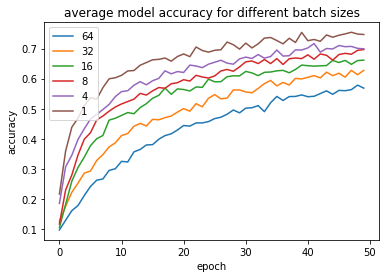

In [27]:
plt.plot(hists[0]["64"]['ave_accuracy'])
plt.plot(hists[1]["32"]["ave_accuracy"])
plt.plot(hists[2]["16"]["ave_accuracy"])
plt.plot(hists[3]["8"]["ave_accuracy"])
plt.plot(hists[4]["4"]["ave_accuracy"])
plt.plot(hists[5]["1"]["ave_accuracy"])
plt.title('average model accuracy for different batch sizes')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(["64","32","16","8","4","1"], loc='upper left')
plt.show()

Average time taken for a single epoch for different Batch Sizes
Size 64: 0.027657718658447267
Size 32: 0.030037708626853094
Size 16: 0.034907814062461656
Size 8: 0.04355084980858697
Size 4: 0.05792997941516694
Size 1: 0.10382289961856954


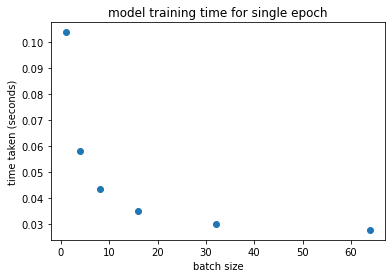

In [28]:
print( "Average time taken for a single epoch for different Batch Sizes")
print( "Size 64:", hists[0]["64"]['ave_time'])
print( "Size 32:", hists[1]["32"]['ave_time'] )
print( "Size 16:", hists[2]["16"]['ave_time'] )
print( "Size 8:", hists[3]["8"]['ave_time'] )
print( "Size 4:", hists[4]["4"]['ave_time'] )
print( "Size 1:", hists[5]["1"]['ave_time'] )

Y = [ hists[0]["64"]['ave_time'],hists[1]["32"]['ave_time'],hists[2]["16"]['ave_time'],hists[3]["8"]['ave_time'],hists[4]["4"]['ave_time'],hists[5]["1"]['ave_time'] ] 
plt.scatter( batch_sizes , Y )
plt.title('model training time for single epoch')
plt.ylabel('time taken (seconds)')
plt.xlabel('batch size')
# plt.legend(['Size: 64', 'Size: 32','Size: 16','Size: 8','Size: 4','Size: 1',], loc='upper left')
plt.show()

### Ideal Batch Size is 16 because takes 0.3 secs per epoch which is half then that of Batch Size of 1 and has training accuracy almost same as that of Batch Size of 1. So it trains quickly and also gives good accuracy

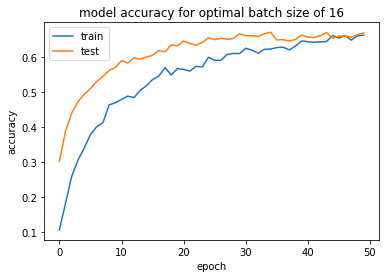

In [29]:
plt.plot(hists[2]["16"]["ave_accuracy"])
ave = ( ( np.array(hists[-2]["4"]["0"].history["val_accuracy"]) + np.array(hists[-2]["4"]["1"].history["val_accuracy"]) + np.array(hists[-2]["4"]["2"].history["val_accuracy"]) )/3 )
plt.plot(ave)
plt.title('model accuracy for optimal batch size of 16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Question 3

In [30]:
neurons = [8,16,32,64]
hists3 = []
BATCH = 16
for neuron in neurons:
    hist_list = []
    for _ind in range(3):
        print("Training For Batch Size",BATCH,"Cross Val",_ind,"neurons",neuron)
        X_train, y_train, X_test, y_test = prepare_dataset(df1, columns_to_drop, test_size=0.3, random_state=0,Kfold = True, start_train= train_[_ind], start_test= test_[_ind])

        y_train_hot = toOneHot(y_train)
        y_test_hot = toOneHot(y_test)

        model = createModel(neuron,1)
        history = trainModel(model,X_train,y_train_hot,X_test,y_test_hot,BATCH,timecallbackobject)
        hist_list.append(history)
        
    aveacc = ( ( np.array(hist_list[0].history["accuracy"]) + np.array(hist_list[1].history["accuracy"]) + np.array(hist_list[2].history["accuracy"]) )/3 )
    batchDict = {str(neuron):{"0":hist_list[0],"1":hist_list[1],"2":hist_list[2],"ave_accuracy":aveacc,"ave_time":( sum(EPOCHS)/len(EPOCHS) ) }}    
    hists3.append(batchDict)
    EPOCHS.clear()

Training For Batch Size 16 Cross Val 0 neurons 8
Epoch 1/50
42/42 [==============================] - 0s 3ms/step - loss: 0.0958 - accuracy: 0.1201 - val_loss: 0.0899 - val_accuracy: 0.1976
Epoch 2/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0894 - accuracy: 0.1862 - val_loss: 0.0832 - val_accuracy: 0.2844
Epoch 3/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0844 - accuracy: 0.2402 - val_loss: 0.0788 - val_accuracy: 0.3533
Epoch 4/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0817 - accuracy: 0.2763 - val_loss: 0.0761 - val_accuracy: 0.3832
Epoch 5/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0788 - accuracy: 0.3123 - val_loss: 0.0740 - val_accuracy: 0.4102
Epoch 6/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0767 - accuracy: 0.3123 - val_loss: 0.0723 - val_accuracy: 0.4281
Epoch 7/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0778 - accuracy: 0.3228 - val_loss: 0

42/42 [==============================] - 0s 924us/step - loss: 0.0744 - accuracy: 0.3688 - val_loss: 0.0734 - val_accuracy: 0.4084
Epoch 9/50
42/42 [==============================] - 0s 973us/step - loss: 0.0739 - accuracy: 0.3388 - val_loss: 0.0721 - val_accuracy: 0.4144
Epoch 10/50
42/42 [==============================] - 0s 973us/step - loss: 0.0728 - accuracy: 0.3808 - val_loss: 0.0711 - val_accuracy: 0.4414
Epoch 11/50
42/42 [==============================] - 0s 924us/step - loss: 0.0715 - accuracy: 0.3883 - val_loss: 0.0700 - val_accuracy: 0.4444
Epoch 12/50
42/42 [==============================] - 0s 900us/step - loss: 0.0701 - accuracy: 0.3838 - val_loss: 0.0688 - val_accuracy: 0.4595
Epoch 13/50
42/42 [==============================] - 0s 924us/step - loss: 0.0705 - accuracy: 0.3958 - val_loss: 0.0680 - val_accuracy: 0.4655
Epoch 14/50
42/42 [==============================] - 0s 973us/step - loss: 0.0699 - accuracy: 0.4123 - val_loss: 0.0672 - val_accuracy: 0.4745
Epoch 15/50


42/42 [==============================] - 0s 949us/step - loss: 0.0724 - accuracy: 0.4063 - val_loss: 0.0679 - val_accuracy: 0.4745
Epoch 16/50
42/42 [==============================] - 0s 949us/step - loss: 0.0707 - accuracy: 0.4408 - val_loss: 0.0670 - val_accuracy: 0.4775
Epoch 17/50
42/42 [==============================] - 0s 973us/step - loss: 0.0707 - accuracy: 0.4093 - val_loss: 0.0662 - val_accuracy: 0.4715
Epoch 18/50
42/42 [==============================] - 0s 973us/step - loss: 0.0693 - accuracy: 0.4198 - val_loss: 0.0653 - val_accuracy: 0.4925
Epoch 19/50
42/42 [==============================] - 0s 924us/step - loss: 0.0688 - accuracy: 0.4288 - val_loss: 0.0644 - val_accuracy: 0.4895
Epoch 20/50
42/42 [==============================] - 0s 997us/step - loss: 0.0666 - accuracy: 0.4498 - val_loss: 0.0636 - val_accuracy: 0.4925
Epoch 21/50
42/42 [==============================] - 0s 973us/step - loss: 0.0668 - accuracy: 0.4408 - val_loss: 0.0629 - val_accuracy: 0.4895
Epoch 22/50

42/42 [==============================] - 0s 973us/step - loss: 0.0561 - accuracy: 0.5811 - val_loss: 0.0524 - val_accuracy: 0.6168
Epoch 23/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0559 - accuracy: 0.5826 - val_loss: 0.0517 - val_accuracy: 0.6168
Epoch 24/50
42/42 [==============================] - 0s 973us/step - loss: 0.0550 - accuracy: 0.5676 - val_loss: 0.0513 - val_accuracy: 0.6168
Epoch 25/50
42/42 [==============================] - 0s 949us/step - loss: 0.0543 - accuracy: 0.5706 - val_loss: 0.0504 - val_accuracy: 0.6228
Epoch 26/50
42/42 [==============================] - 0s 924us/step - loss: 0.0549 - accuracy: 0.5796 - val_loss: 0.0505 - val_accuracy: 0.6048
Epoch 27/50
42/42 [==============================] - 0s 949us/step - loss: 0.0548 - accuracy: 0.5766 - val_loss: 0.0497 - val_accuracy: 0.6078
Epoch 28/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0549 - accuracy: 0.5781 - val_loss: 0.0496 - val_accuracy: 0.6257
Epoch 29/50
42/

42/42 [==============================] - 0s 973us/step - loss: 0.0525 - accuracy: 0.5847 - val_loss: 0.0573 - val_accuracy: 0.5195
Epoch 30/50
42/42 [==============================] - 0s 973us/step - loss: 0.0517 - accuracy: 0.6027 - val_loss: 0.0572 - val_accuracy: 0.5165
Epoch 31/50
42/42 [==============================] - 0s 973us/step - loss: 0.0528 - accuracy: 0.5862 - val_loss: 0.0570 - val_accuracy: 0.5435
Epoch 32/50
42/42 [==============================] - 0s 949us/step - loss: 0.0503 - accuracy: 0.6177 - val_loss: 0.0566 - val_accuracy: 0.5285
Epoch 33/50
42/42 [==============================] - ETA: 0s - loss: 0.0425 - accuracy: 0.56 - 0s 1ms/step - loss: 0.0501 - accuracy: 0.6222 - val_loss: 0.0562 - val_accuracy: 0.5345
Epoch 34/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0499 - accuracy: 0.6117 - val_loss: 0.0559 - val_accuracy: 0.5465
Epoch 35/50
42/42 [==============================] - 0s 973us/step - loss: 0.0498 - accuracy: 0.6252 - val_loss: 0.0

42/42 [==============================] - 0s 1ms/step - loss: 0.0505 - accuracy: 0.6057 - val_loss: 0.0468 - val_accuracy: 0.6637
Epoch 37/50
42/42 [==============================] - 0s 973us/step - loss: 0.0505 - accuracy: 0.6147 - val_loss: 0.0466 - val_accuracy: 0.6667
Epoch 38/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0481 - accuracy: 0.6252 - val_loss: 0.0467 - val_accuracy: 0.6637
Epoch 39/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0488 - accuracy: 0.6342 - val_loss: 0.0464 - val_accuracy: 0.6697
Epoch 40/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0466 - accuracy: 0.6612 - val_loss: 0.0458 - val_accuracy: 0.6757
Epoch 41/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0482 - accuracy: 0.6327 - val_loss: 0.0456 - val_accuracy: 0.6637
Epoch 42/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0482 - accuracy: 0.6162 - val_loss: 0.0455 - val_accuracy: 0.6607
Epoch 43/50
42/42 [====

42/42 [==============================] - 0s 1ms/step - loss: 0.0345 - accuracy: 0.7763 - val_loss: 0.0393 - val_accuracy: 0.7275
Epoch 44/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0353 - accuracy: 0.7508 - val_loss: 0.0392 - val_accuracy: 0.7246
Epoch 45/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0347 - accuracy: 0.7613 - val_loss: 0.0391 - val_accuracy: 0.7156
Epoch 46/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0371 - accuracy: 0.7447 - val_loss: 0.0394 - val_accuracy: 0.7036
Epoch 47/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0336 - accuracy: 0.7763 - val_loss: 0.0392 - val_accuracy: 0.7126
Epoch 48/50
42/42 [==============================] - 0s 997us/step - loss: 0.0344 - accuracy: 0.7703 - val_loss: 0.0386 - val_accuracy: 0.7096
Epoch 49/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0337 - accuracy: 0.7808 - val_loss: 0.0384 - val_accuracy: 0.7066
Epoch 50/50
42/42 [====

42/42 [==============================] - 0s 1ms/step - loss: 0.0328 - accuracy: 0.7706 - val_loss: 0.0484 - val_accuracy: 0.6396
Training For Batch Size 16 Cross Val 2 neurons 32
Epoch 1/50
42/42 [==============================] - 0s 3ms/step - loss: 0.0999 - accuracy: 0.0885 - val_loss: 0.0921 - val_accuracy: 0.1351
Epoch 2/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0903 - accuracy: 0.1949 - val_loss: 0.0827 - val_accuracy: 0.2793
Epoch 3/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0810 - accuracy: 0.3043 - val_loss: 0.0748 - val_accuracy: 0.3634
Epoch 4/50
42/42 [==============================] - 0s 997us/step - loss: 0.0761 - accuracy: 0.3433 - val_loss: 0.0706 - val_accuracy: 0.3904
Epoch 5/50
42/42 [==============================] - 0s 997us/step - loss: 0.0715 - accuracy: 0.3898 - val_loss: 0.0678 - val_accuracy: 0.4535
Epoch 6/50
42/42 [==============================] - 0s 973us/step - loss: 0.0675 - accuracy: 0.4273 - val_loss: 0.065

42/42 [==============================] - 0s 949us/step - loss: 0.0544 - accuracy: 0.6006 - val_loss: 0.0518 - val_accuracy: 0.6287
Epoch 8/50
42/42 [==============================] - 0s 973us/step - loss: 0.0537 - accuracy: 0.6186 - val_loss: 0.0500 - val_accuracy: 0.6377
Epoch 9/50
42/42 [==============================] - 0s 949us/step - loss: 0.0496 - accuracy: 0.6396 - val_loss: 0.0482 - val_accuracy: 0.6497
Epoch 10/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0482 - accuracy: 0.6547 - val_loss: 0.0469 - val_accuracy: 0.6587
Epoch 11/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0486 - accuracy: 0.6441 - val_loss: 0.0466 - val_accuracy: 0.6617
Epoch 12/50
42/42 [==============================] - 0s 973us/step - loss: 0.0441 - accuracy: 0.6772 - val_loss: 0.0447 - val_accuracy: 0.6856
Epoch 13/50
42/42 [==============================] - 0s 949us/step - loss: 0.0430 - accuracy: 0.6922 - val_loss: 0.0435 - val_accuracy: 0.6856
Epoch 14/50
42/42

42/42 [==============================] - 0s 997us/step - loss: 0.0387 - accuracy: 0.7241 - val_loss: 0.0502 - val_accuracy: 0.6186
Epoch 15/50
42/42 [==============================] - 0s 973us/step - loss: 0.0363 - accuracy: 0.7586 - val_loss: 0.0492 - val_accuracy: 0.6246
Epoch 16/50
42/42 [==============================] - 0s 997us/step - loss: 0.0372 - accuracy: 0.7361 - val_loss: 0.0488 - val_accuracy: 0.6276
Epoch 17/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0348 - accuracy: 0.7646 - val_loss: 0.0497 - val_accuracy: 0.6336
Epoch 18/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0344 - accuracy: 0.7691 - val_loss: 0.0484 - val_accuracy: 0.6276
Epoch 19/50
42/42 [==============================] - 0s 949us/step - loss: 0.0323 - accuracy: 0.7766 - val_loss: 0.0474 - val_accuracy: 0.6396
Epoch 20/50
42/42 [==============================] - 0s 949us/step - loss: 0.0335 - accuracy: 0.7676 - val_loss: 0.0469 - val_accuracy: 0.6276
Epoch 21/50
42/

42/42 [==============================] - 0s 1ms/step - loss: 0.0338 - accuracy: 0.7676 - val_loss: 0.0443 - val_accuracy: 0.6517
Epoch 22/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0315 - accuracy: 0.7871 - val_loss: 0.0439 - val_accuracy: 0.6577
Epoch 23/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0315 - accuracy: 0.7886 - val_loss: 0.0436 - val_accuracy: 0.6727
Epoch 24/50
42/42 [==============================] - 0s 997us/step - loss: 0.0309 - accuracy: 0.7961 - val_loss: 0.0432 - val_accuracy: 0.6727
Epoch 25/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0312 - accuracy: 0.7946 - val_loss: 0.0432 - val_accuracy: 0.6757
Epoch 26/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0290 - accuracy: 0.8141 - val_loss: 0.0426 - val_accuracy: 0.6817
Epoch 27/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0293 - accuracy: 0.8036 - val_loss: 0.0423 - val_accuracy: 0.6757
Epoch 28/50
42/42 [====

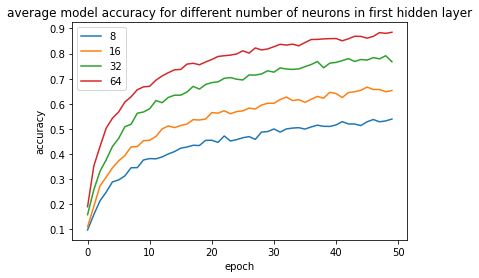

In [31]:
plt.plot(hists3[0]["8"]['ave_accuracy'])
plt.plot(hists3[1]["16"]["ave_accuracy"])
plt.plot(hists3[2]["32"]["ave_accuracy"])
plt.plot(hists3[3]["64"]["ave_accuracy"])
plt.title('average model accuracy for different number of neurons in first hidden layer')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend( ["8","16","32","64"], loc='upper left')
plt.show()

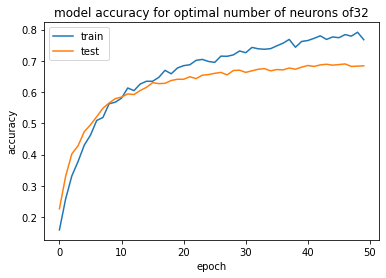

In [32]:
NEURONS = "32"
ind = -2
plt.plot(hists3[ind][NEURONS]["ave_accuracy"])
ave = ( ( np.array(hists3[ind][NEURONS]["0"].history["val_accuracy"]) + np.array(hists3[ind][NEURONS]["1"].history["val_accuracy"]) + np.array(hists3[ind][NEURONS]["2"].history["val_accuracy"]) )/3 )
plt.plot(ave)
plt.title('model accuracy for optimal number of neurons of'+NEURONS)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 32 number of neurons are optimal since it gives the highest accuracy

### Question 4

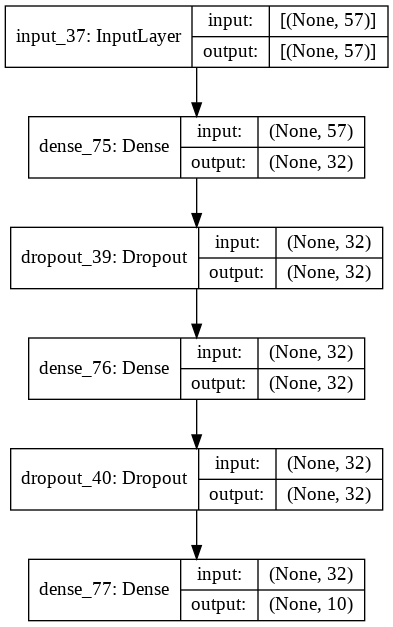

In [33]:
keras.utils.plot_model(createModel(32,2), show_shapes=True)

In [33]:
hists4 = []
neurons = 32
batchsize = 1
layers = 2
hist_list = []
for _ind in range(3):
    print("Training For Batch Size",batchsize,"Cross Val",_ind,"neurons",neurons)
    X_train, y_train, X_test, y_test = prepare_dataset(df1, columns_to_drop, test_size=0.3, random_state=0,Kfold = True, start_train= train_[_ind], start_test= test_[_ind])

    y_train_hot = toOneHot(y_train)
    y_test_hot = toOneHot(y_test)

    model = createModel(neurons,layers)
    history = trainModel(model,X_train,y_train_hot,X_test,y_test_hot,batchsize,timecallbackobject)
    hist_list.append(history)
        
aveacc = ( ( np.array(hist_list[0].history["accuracy"]) + np.array(hist_list[1].history["accuracy"]) + np.array(hist_list[2].history["accuracy"]) )/3 )
batchDict = {str(neurons):{"0":hist_list[0],"1":hist_list[1],"2":hist_list[2],"ave_accuracy":aveacc,"ave_time":( sum(EPOCHS)/len(EPOCHS) ) }}    
hists4.append(batchDict)
EPOCHS.clear()

Training For Batch Size 1 Cross Val 0 neurons 32
Epoch 1/50
666/666 [==============================] - 1s 960us/step - loss: 0.0907 - accuracy: 0.1787 - val_loss: 0.0756 - val_accuracy: 0.3593
Epoch 2/50
666/666 [==============================] - 1s 1ms/step - loss: 0.0796 - accuracy: 0.3078 - val_loss: 0.0665 - val_accuracy: 0.4461
Epoch 3/50
666/666 [==============================] - 1s 772us/step - loss: 0.0737 - accuracy: 0.4054 - val_loss: 0.0584 - val_accuracy: 0.5509
Epoch 4/50
666/666 [==============================] - 0s 669us/step - loss: 0.0675 - accuracy: 0.4339 - val_loss: 0.0588 - val_accuracy: 0.5659
Epoch 5/50
666/666 [==============================] - 0s 616us/step - loss: 0.0626 - accuracy: 0.4970 - val_loss: 0.0523 - val_accuracy: 0.5868
Epoch 6/50
666/666 [==============================] - 0s 610us/step - loss: 0.0612 - accuracy: 0.5240 - val_loss: 0.0493 - val_accuracy: 0.6257
Epoch 7/50
666/666 [==============================] - 0s 672us/step - loss: 0.0560 - accu

Epoch 7/50
667/667 [==============================] - 1s 813us/step - loss: 0.0562 - accuracy: 0.5397 - val_loss: 0.0573 - val_accuracy: 0.5495
Epoch 8/50
667/667 [==============================] - 0s 741us/step - loss: 0.0533 - accuracy: 0.5892 - val_loss: 0.0556 - val_accuracy: 0.5826
Epoch 9/50
667/667 [==============================] - 0s 639us/step - loss: 0.0523 - accuracy: 0.5832 - val_loss: 0.0553 - val_accuracy: 0.5826
Epoch 10/50
667/667 [==============================] - 1s 821us/step - loss: 0.0499 - accuracy: 0.6252 - val_loss: 0.0554 - val_accuracy: 0.5616
Epoch 11/50
667/667 [==============================] - 1s 824us/step - loss: 0.0481 - accuracy: 0.6327 - val_loss: 0.0552 - val_accuracy: 0.5886
Epoch 12/50
667/667 [==============================] - 0s 686us/step - loss: 0.0465 - accuracy: 0.6522 - val_loss: 0.0555 - val_accuracy: 0.6006
Epoch 13/50
667/667 [==============================] - 0s 645us/step - loss: 0.0454 - accuracy: 0.6597 - val_loss: 0.0548 - val_accur

667/667 [==============================] - 0s 612us/step - loss: 0.0478 - accuracy: 0.6432 - val_loss: 0.0463 - val_accuracy: 0.6336
Epoch 14/50
667/667 [==============================] - 0s 630us/step - loss: 0.0477 - accuracy: 0.6387 - val_loss: 0.0455 - val_accuracy: 0.6486
Epoch 15/50
667/667 [==============================] - 0s 663us/step - loss: 0.0465 - accuracy: 0.6687 - val_loss: 0.0456 - val_accuracy: 0.6697
Epoch 16/50
667/667 [==============================] - 0s 660us/step - loss: 0.0464 - accuracy: 0.6807 - val_loss: 0.0472 - val_accuracy: 0.6486
Epoch 17/50
667/667 [==============================] - 0s 636us/step - loss: 0.0436 - accuracy: 0.6702 - val_loss: 0.0435 - val_accuracy: 0.6817
Epoch 18/50
667/667 [==============================] - 0s 621us/step - loss: 0.0442 - accuracy: 0.6762 - val_loss: 0.0421 - val_accuracy: 0.6787
Epoch 19/50
667/667 [==============================] - 0s 657us/step - loss: 0.0430 - accuracy: 0.6822 - val_loss: 0.0431 - val_accuracy: 0.66

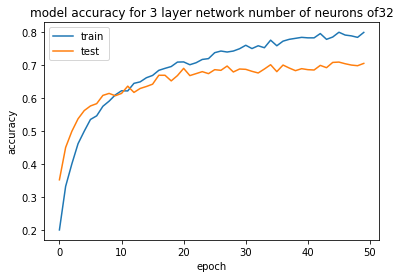

In [34]:
NEURONS = "32"
ind = 0
plt.plot(hists4[ind][NEURONS]["ave_accuracy"])
ave = ( ( np.array(hists4[ind][NEURONS]["0"].history["val_accuracy"]) + np.array(hists4[ind][NEURONS]["1"].history["val_accuracy"]) + np.array(hists4[ind][NEURONS]["2"].history["val_accuracy"]) )/3 )
plt.plot(ave)
plt.title('model accuracy for 3 layer network number of neurons of'+NEURONS)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

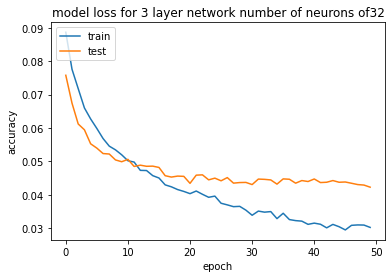

In [35]:
NEURONS = "32"
ind = 0
ave2 = ( ( np.array(hists4[ind][NEURONS]["0"].history["loss"]) + np.array(hists4[ind][NEURONS]["1"].history["loss"]) + np.array(hists4[ind][NEURONS]["2"].history["loss"]) )/3 )

plt.plot(ave2)
ave = ( ( np.array(hists4[ind][NEURONS]["0"].history["val_loss"]) + np.array(hists4[ind][NEURONS]["1"].history["val_loss"]) + np.array(hists4[ind][NEURONS]["2"].history["val_loss"]) )/3 )

plt.plot(ave)
plt.title('model loss for 3 layer network number of neurons of'+NEURONS)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Question 5

In [36]:
hists5 = []
neurons = 32
batchsize = 32
layers = 2
hist_list = []
for _ind in range(3):
    print("Training For Batch Size",batchsize,"Cross Val",_ind,"neurons",neurons)
    X_train, y_train, X_test, y_test = prepare_dataset(df1, columns_to_drop, test_size=0.3, random_state=0,Kfold = True, start_train= train_[_ind], start_test= test_[_ind])

    y_train_hot = toOneHot(y_train)
    y_test_hot = toOneHot(y_test)

    model = createModel(neurons,layers,dropout = False)
    history = trainModel(model,X_train,y_train_hot,X_test,y_test_hot,batchsize,timecallbackobject)
    hist_list.append(history)
        
aveacc = ( ( np.array(hist_list[0].history["accuracy"]) + np.array(hist_list[1].history["accuracy"]) + np.array(hist_list[2].history["accuracy"]) )/3 )
batchDict = {str(neurons):{"0":hist_list[0],"1":hist_list[1],"2":hist_list[2],"ave_accuracy":aveacc,"ave_time":( sum(EPOCHS)/len(EPOCHS) ) }}    
hists5.append(batchDict)
EPOCHS.clear()

Training For Batch Size 32 Cross Val 0 neurons 32
Epoch 1/50
21/21 [==============================] - 0s 5ms/step - loss: 0.0910 - accuracy: 0.1306 - val_loss: 0.0873 - val_accuracy: 0.2186
Epoch 2/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0830 - accuracy: 0.2943 - val_loss: 0.0805 - val_accuracy: 0.3174
Epoch 3/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0760 - accuracy: 0.3649 - val_loss: 0.0746 - val_accuracy: 0.3713
Epoch 4/50
21/21 [==============================] - 0s 2ms/step - loss: 0.0695 - accuracy: 0.4294 - val_loss: 0.0700 - val_accuracy: 0.3922
Epoch 5/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0645 - accuracy: 0.4820 - val_loss: 0.0659 - val_accuracy: 0.4581
Epoch 6/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0602 - accuracy: 0.5390 - val_loss: 0.0627 - val_accuracy: 0.4940
Epoch 7/50
21/21 [==============================] - ETA: 0s - loss: 0.0467 - accuracy: 0.62 - 0s 1ms/step - lo

21/21 [==============================] - 0s 1ms/step - loss: 0.0540 - accuracy: 0.5877 - val_loss: 0.0648 - val_accuracy: 0.4625
Epoch 9/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0510 - accuracy: 0.6087 - val_loss: 0.0634 - val_accuracy: 0.4625
Epoch 10/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0483 - accuracy: 0.6282 - val_loss: 0.0619 - val_accuracy: 0.4985
Epoch 11/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0459 - accuracy: 0.6567 - val_loss: 0.0610 - val_accuracy: 0.5015
Epoch 12/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0437 - accuracy: 0.6672 - val_loss: 0.0595 - val_accuracy: 0.5315
Epoch 13/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0417 - accuracy: 0.7076 - val_loss: 0.0582 - val_accuracy: 0.5405
Epoch 14/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0398 - accuracy: 0.7361 - val_loss: 0.0572 - val_accuracy: 0.5556
Epoch 15/50
21/21 [=======

Epoch 16/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0369 - accuracy: 0.7496 - val_loss: 0.0490 - val_accuracy: 0.6336
Epoch 17/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0350 - accuracy: 0.7586 - val_loss: 0.0486 - val_accuracy: 0.6186
Epoch 18/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0335 - accuracy: 0.7946 - val_loss: 0.0478 - val_accuracy: 0.6456
Epoch 19/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0320 - accuracy: 0.7961 - val_loss: 0.0476 - val_accuracy: 0.6577
Epoch 20/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0307 - accuracy: 0.8066 - val_loss: 0.0471 - val_accuracy: 0.6577
Epoch 21/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0296 - accuracy: 0.8186 - val_loss: 0.0464 - val_accuracy: 0.6577
Epoch 22/50
21/21 [==============================] - 0s 1ms/step - loss: 0.0285 - accuracy: 0.8261 - val_loss: 0.0460 - val_accuracy: 0.6757
Epoch 23/50
2

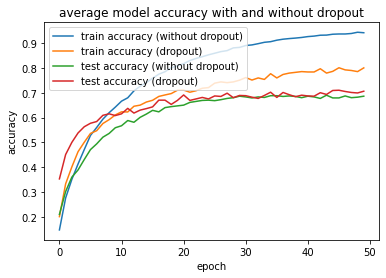

In [37]:
plt.plot(hists5[0]["32"]['ave_accuracy'])
plt.plot(hists4[0]["32"]["ave_accuracy"])
ave5 = ( ( np.array(hists5[0]["32"]["0"].history["val_accuracy"]) + np.array(hists5[0]["32"]["1"].history["val_accuracy"]) + np.array(hists5[0]["32"]["2"].history["val_accuracy"]) )/3 )
ave4 = ( ( np.array(hists4[ind][NEURONS]["0"].history["val_accuracy"]) + np.array(hists4[ind][NEURONS]["1"].history["val_accuracy"]) + np.array(hists4[ind][NEURONS]["2"].history["val_accuracy"]) )/3 )

plt.plot(ave5)
plt.plot(ave4)
plt.title('average model accuracy with and without dropout')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend( ["train accuracy (without dropout)","train accuracy (dropout)","test accuracy (without dropout)","test accuracy (dropout)"], loc='upper left')
plt.show()

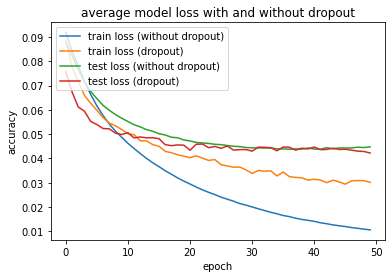

In [38]:
plt.plot(( ( np.array(hists5[0]["32"]["0"].history["loss"]) + np.array(hists5[0]["32"]["1"].history["loss"]) + np.array(hists5[0]["32"]["2"].history["loss"]) )/3 ))
plt.plot(( ( np.array(hists4[ind][NEURONS]["0"].history["loss"]) + np.array(hists4[ind][NEURONS]["1"].history["loss"]) + np.array(hists4[ind][NEURONS]["2"].history["loss"]) )/3 ))
ave5 = ( ( np.array(hists5[0]["32"]["0"].history["val_loss"]) + np.array(hists5[0]["32"]["1"].history["val_loss"]) + np.array(hists5[0]["32"]["2"].history["val_loss"]) )/3 )
ave4 = ( ( np.array(hists4[ind][NEURONS]["0"].history["val_loss"]) + np.array(hists4[ind][NEURONS]["1"].history["val_loss"]) + np.array(hists4[ind][NEURONS]["2"].history["val_loss"]) )/3 )

plt.plot(ave5)
plt.plot(ave4)
plt.title('average model loss with and without dropout')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend( ["train loss (without dropout)","train loss (dropout)","test loss (without dropout)","test loss (dropout)"], loc='upper left')
plt.show()